In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepcV2 as qem

Cost after step     5:  1.6681890
Cost after step    10:  0.4863150
Cost after step    15:  0.1769918
Cost after step    20:  0.1812717
Cost after step    25:  0.1372719
Cost after step    30:  0.1295318
Cost after step    35:  0.0545087
Cost after step    40:  0.0433409
Cost after step    45:  0.0255060
Cost after step    50:  0.0467387
Cost after step    55:  0.1216610
Cost after step    60:  0.0307070
Cost after step    65:  0.0317647
Cost after step    70:  0.0769897
Cost after step    75:  0.0495092
Cost after step    80:  0.0251403
Cost after step    85:  0.1172622
Cost after step    90:  0.1063679
Cost after step    95:  0.1353931
Cost after step   100:  0.0351169
Optimized rotation angles: [[[ 0.39554039  1.12166032  0.02012015]
  [ 0.88175811  0.33990017  0.27935658]]

 [[-0.01152569  2.80078114  0.1979649 ]
  [ 0.84681242  0.20619414  0.41612375]]]


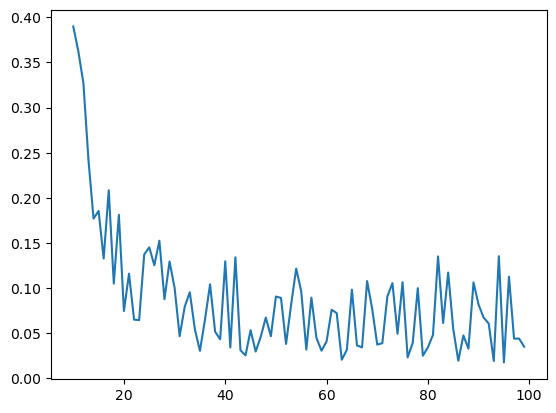

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (qml.QNode(qemzmsepc.noise_circuit, dev)(train_cir_without_qem, x, p=p,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel,
            need_gate_noise=True, need_measurement_noise=True) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

Cost after step     5:  0.2067636
Cost after step    10:  0.0581612
Cost after step    15:  0.0268348
Cost after step    20:  0.0154383
Cost after step    25:  0.0100438
Cost after step    30:  0.0070653
Cost after step    35:  0.0052458
Cost after step    40:  0.0040519
Cost after step    45:  0.0032258
Cost after step    50:  0.0026300
Cost after step    55:  0.0021860
Cost after step    60:  0.0018462
Cost after step    65:  0.0015803
Cost after step    70:  0.0013681
Cost after step    75:  0.0011962
Cost after step    80:  0.0010549
Cost after step    85:  0.0009373
Cost after step    90:  0.0008384
Cost after step    95:  0.0007544
Cost after step   100:  0.0006825
Optimized rotation angles: [[[ 0.86076007  1.42053302  0.18145264]
  [ 0.6030414   1.28323284  0.09935966]]

 [[-0.08315388  1.82691758  0.13079376]
  [ 0.77747264  0.19200512  0.82962307]]]


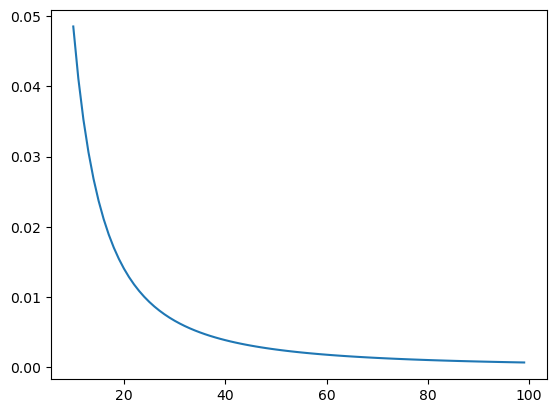

In [3]:
# training with QEM-ZMSEPC method

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_with_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    z_miti, _ = qemzmsepc.qemzmsepc(train_cir_with_qem, p, dev, x,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    return (z_miti - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()